<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/init_32_49__mssim_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pytorch-msssim

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as skimage_ssim
from skimage.metrics import peak_signal_noise_ratio
import time
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from pytorch_msssim import MS_SSIM, ms_ssim, ssim, SSIM


In [9]:
class MS_SSIM_Loss(MS_SSIM):
    def forward(self, img1, img2):
        return 100*( 1 - super(MS_SSIM_Loss, self).forward(img1, img2) )


In [10]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device


In [11]:
start = time.time()

transform_randomcrop = transforms.Compose([
     transforms.RandomCrop(256,256),
     transforms.ToTensor()
    ])
#transforms이라는 compose를 만들면 module error 발생

train_set = datasets.Places365(root = "/data",split ='val', transform = transform_randomcrop, download = False)#처음 설치하는 것이면 : download = True

end = time.time()

total_time = (end-start)/60

print("Download time : {:.1f}min".format(total_time))

Download time : 0.0min


In [12]:
tr_subset, val_subset = torch.utils.data.random_split(train_set, [32850,3650], generator=torch.Generator().manual_seed(1))

In [13]:
batch_size = 32
torch.manual_seed(1)
torch.cuda.manual_seed(1)

Original Train/Validation/Test dataset

In [17]:
tr_dataloader = DataLoader(tr_subset, batch_size=batch_size,drop_last=True, num_workers=0)
val_dataloader = DataLoader(val_subset, batch_size=batch_size,drop_last=True, num_workers=0)

#Drop last를 해야지 val_img를 32개 전부 뽑을 수 있다

In [40]:
## 한 개의 sequential로 구성 했을 때의 학습 속도 1.3min이면 동일, 최대 ssim, loss
class Autoencoder(nn.Module):
   def __init__(self):
       super(Autoencoder, self).__init__()
       init_ch  = 32
       latent_dim = 100 
       self.encoder = nn.Sequential(

           nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2, bias=False),#추가
           nn.BatchNorm2d(3),
           nn.ReLU(),

           nn.Conv2d(in_channels=3, out_channels=init_ch, kernel_size=5, stride=1, padding=2, bias=False),
           nn.BatchNorm2d(init_ch),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=2, stride=2),

           nn.Conv2d(in_channels=init_ch, out_channels=int(init_ch/2), kernel_size=5, stride=1, padding=2,  bias=False),
           nn.BatchNorm2d(int(init_ch/2)),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=2, stride=2),

           nn.Conv2d(in_channels=int(init_ch/2), out_channels=int(init_ch/4), kernel_size=5, stride=1, padding=2,  bias=False),
           nn.BatchNorm2d(int(init_ch/4)),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=2, stride=2),

           nn.Conv2d(in_channels=int(init_ch/4), out_channels=latent_dim, kernel_size=5, stride=1, padding=2, bias=False),#추가
           nn.Conv2d(in_channels=latent_dim, out_channels=latent_dim, kernel_size=5, stride=1, padding=2,  bias=False), #latent_factor
           nn.ReLU(),                     
        )
       
       self.decoder = nn.Sequential(
           nn.ConvTranspose2d(in_channels=latent_dim, out_channels=int(init_ch/4), kernel_size=5, stride=1, padding=2, bias=False),#추가
           nn.ConvTranspose2d(in_channels=int(init_ch/4), out_channels=int(init_ch/4), kernel_size=5, stride=1, padding=2, bias=False),
           nn.BatchNorm2d(int(init_ch/4)),
           nn.ReLU(),

           nn.UpsamplingBilinear2d(scale_factor = 2),
           nn.ConvTranspose2d(in_channels=int(init_ch/4), out_channels=int(init_ch/2), kernel_size=5, stride=1, padding=2, bias=False),
           nn.BatchNorm2d(int(init_ch/2)),
           nn.ReLU(),

           nn.UpsamplingBilinear2d(scale_factor = 2),         
           nn.ConvTranspose2d(in_channels=int(init_ch/2), out_channels=init_ch, kernel_size=5, stride=1, padding=2,  bias=False),#추가
           nn.BatchNorm2d(init_ch),
           nn.ReLU(),

           nn.UpsamplingBilinear2d(scale_factor = 2),
           nn.ConvTranspose2d(in_channels=init_ch, out_channels=3, kernel_size=5, stride=1, padding=2, bias=False),
           nn.BatchNorm2d(3),
           nn.ReLU(),
           
           nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2, bias=False),
           nn.Sigmoid()  

       )


   def forward(self, x):
       x = self.encoder(x)
       x = self.decoder(x)
    
       return x

In [35]:
# #Test.py

# model.eval()
# with torch.no_grad():
#     optimizer.zero_grad()

#     for i, (val_img,_) in enumerate(val_dataloader):
#             val_img = val_img.to(device)
#             val_outputs =model(val_img)
#             val_ms_ssim_loss = ms_ssim_loss_fn(val_outputs,val_img)
#             val_loss = val_ms_ssim_loss.cpu().item()
#             total_val_loss += val_loss
#     total_val_loss = total_val_loss/len(val_dataloader)
#     val_loss_graph = np.append(val_loss_graph, total_val_loss)
#     print('Train Loss: {:.6f}\t val Loss: {:.6f}\t lr : {}'.format(total_train_loss, total_val_loss, scheduler.optimizer.state_dict()['param_groups'][0]['lr']))


#     if (epoch)%1 == 0:
#         total_psnr = 0
#         total_ssim = 0
#         for j in range(5):
#             val_ssim = skimage_ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True)
#             val_psnr = peak_signal_noise_ratio(val_img[j].cpu().numpy().transpose(1,2,0), val_outputs[j].cpu().numpy().transpose(1,2,0))
#             total_psnr += val_psnr
#             total_ssim += val_ssim
#             print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
#             ax = plt.subplot(2,5,j+1)
#             plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
#             ax.get_xaxis().set_visible(False)
#             ax.get_yaxis().set_visible(False)

#             ax = plt.subplot(2,5,j+5+1)
#             plt.imshow(val_outputs[j].int().cpu().numpy().transpose(1, 2, 0))
#             ax.get_xaxis().set_visible(False)
#             ax.get_yaxis().set_visible(False)
#         print('average_PNSR :{:.2f} \t average_SSIM : {:.2f}'.format(total_psnr/5,total_ssim/5))
#         plt.show()

KeyboardInterrupt: ignored

PNSR :22.42 	 SSIM : 0.97
PNSR :27.21 	 SSIM : 0.93
PNSR :19.07 	 SSIM : 0.66
PNSR :22.35 	 SSIM : 0.85
PNSR :20.31 	 SSIM : 0.90
average_PNSR :22.27 	 average_SSIM : 0.86


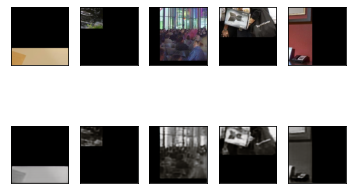

In [37]:
#Test visualization 

total_psnr = 0
total_ssim = 0
for j in range(5):
    val_ssim = skimage_ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True)
    val_psnr = peak_signal_noise_ratio(val_img[j].cpu().numpy().transpose(1,2,0), val_outputs[j].cpu().numpy().transpose(1,2,0))
    total_psnr += val_psnr
    total_ssim += val_ssim
    print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
    ax = plt.subplot(2,5,j+1)
    plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2,5,j+5+1)
    plt.imshow(val_outputs[j].cpu().numpy().transpose(1, 2, 0))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
print('average_PNSR :{:.2f} \t average_SSIM : {:.2f}'.format(total_psnr/5,total_ssim/5))
plt.show()

# Model. Setting parameter -> float

cuda
Epoch : [1/50] 

Train Loss: 13.419058	 val Loss: 8.641304	 lr : 0.001
PNSR :22.07 	 SSIM : 0.83
PNSR :20.22 	 SSIM : 0.90
PNSR :23.30 	 SSIM : 0.92
PNSR :30.91 	 SSIM : 0.94
PNSR :21.84 	 SSIM : 0.83
average_PNSR :23.67 	 average_SSIM : 0.88


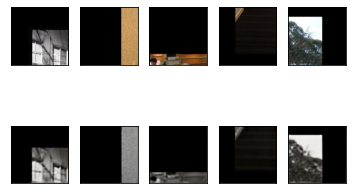

Epoch : [2/50] 

Train Loss: 8.244374	 val Loss: 7.394257	 lr : 0.001
PNSR :44.28 	 SSIM : 0.99
PNSR :14.64 	 SSIM : 0.58
PNSR :19.46 	 SSIM : 0.69
PNSR :39.74 	 SSIM : 0.98
PNSR :33.07 	 SSIM : 0.96
average_PNSR :30.24 	 average_SSIM : 0.84


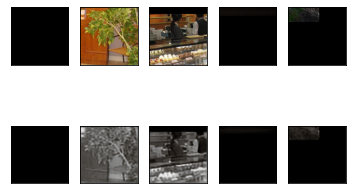

Epoch : [3/50] 

Train Loss: 7.405819	 val Loss: 7.312731	 lr : 0.001
PNSR :21.75 	 SSIM : 0.84
PNSR :14.49 	 SSIM : 0.71
PNSR :23.22 	 SSIM : 0.91
PNSR :43.69 	 SSIM : 0.99
PNSR :34.13 	 SSIM : 0.97
average_PNSR :27.46 	 average_SSIM : 0.89


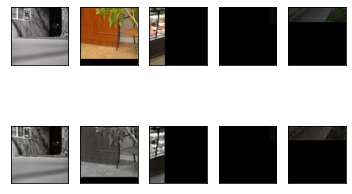

Epoch : [4/50] 

Train Loss: 6.940676	 val Loss: 6.797563	 lr : 0.001
PNSR :22.08 	 SSIM : 0.98
PNSR :14.48 	 SSIM : 0.69
PNSR :19.84 	 SSIM : 0.76
PNSR :35.14 	 SSIM : 0.96
PNSR :20.90 	 SSIM : 0.75
average_PNSR :22.49 	 average_SSIM : 0.83


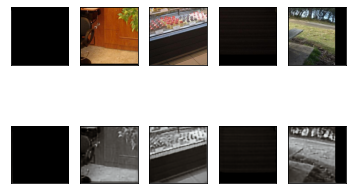

Epoch : [5/50] 

Train Loss: 6.705875	 val Loss: 6.364031	 lr : 0.001
PNSR :27.78 	 SSIM : 0.95
PNSR :19.79 	 SSIM : 0.80
PNSR :33.02 	 SSIM : 0.99
PNSR :21.38 	 SSIM : 0.78
PNSR :30.36 	 SSIM : 0.93
average_PNSR :26.47 	 average_SSIM : 0.89


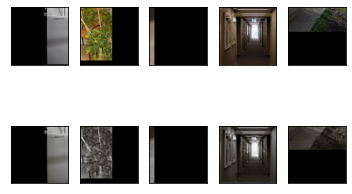

Epoch : [6/50] 

Train Loss: 6.515138	 val Loss: 6.251979	 lr : 0.001
PNSR :33.38 	 SSIM : 0.99
PNSR :27.96 	 SSIM : 0.99
PNSR :18.98 	 SSIM : 0.71
PNSR :29.60 	 SSIM : 0.96
PNSR :25.61 	 SSIM : 0.87
average_PNSR :27.11 	 average_SSIM : 0.90


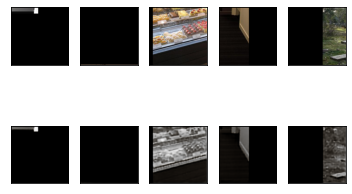

Epoch : [7/50] 

Train Loss: 6.459326	 val Loss: 6.414473	 lr : 0.001
PNSR :23.23 	 SSIM : 0.83
PNSR :28.41 	 SSIM : 0.99
PNSR :28.06 	 SSIM : 0.97
PNSR :26.39 	 SSIM : 0.95
PNSR :31.58 	 SSIM : 0.99
average_PNSR :27.53 	 average_SSIM : 0.95


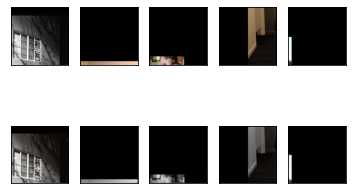

Epoch : [8/50] 

Train Loss: 6.283016	 val Loss: 5.927491	 lr : 0.001
PNSR :32.14 	 SSIM : 1.00
PNSR :30.15 	 SSIM : 0.99
PNSR :30.83 	 SSIM : 1.00
PNSR :20.97 	 SSIM : 0.84
PNSR :23.16 	 SSIM : 0.90
average_PNSR :27.45 	 average_SSIM : 0.94


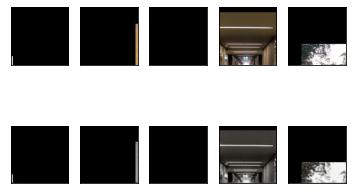

Epoch : [9/50] 

Train Loss: 6.203754	 val Loss: 5.987069	 lr : 0.001
PNSR :36.35 	 SSIM : 0.98
PNSR :17.72 	 SSIM : 0.80
PNSR :21.56 	 SSIM : 0.85
PNSR :31.82 	 SSIM : 0.99
PNSR :20.00 	 SSIM : 0.69
average_PNSR :25.49 	 average_SSIM : 0.86


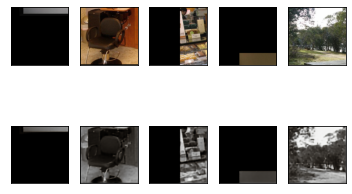

Epoch : [10/50] 

Train Loss: 6.084381	 val Loss: 6.117016	 lr : 0.001
PNSR :35.36 	 SSIM : 0.98
PNSR :16.42 	 SSIM : 0.65
PNSR :21.18 	 SSIM : 0.80
PNSR :26.55 	 SSIM : 0.95
PNSR :21.60 	 SSIM : 0.76
average_PNSR :24.22 	 average_SSIM : 0.83


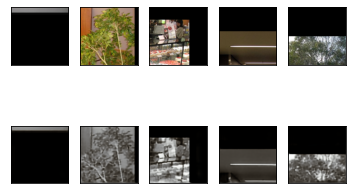

Epoch : [11/50] 

Train Loss: 5.969815	 val Loss: 6.380517	 lr : 0.001
PNSR :36.23 	 SSIM : 0.98
PNSR :24.13 	 SSIM : 0.96
PNSR :24.39 	 SSIM : 0.91
PNSR :45.46 	 SSIM : 1.00
PNSR :25.08 	 SSIM : 0.94
average_PNSR :31.06 	 average_SSIM : 0.96


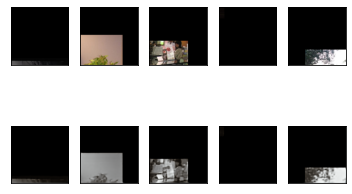

Epoch : [12/50] 

Train Loss: 5.933875	 val Loss: 6.212202	 lr : 0.001
PNSR :24.82 	 SSIM : 0.90
PNSR :16.84 	 SSIM : 0.87
PNSR :23.61 	 SSIM : 0.91
PNSR :28.74 	 SSIM : 0.94
PNSR :20.37 	 SSIM : 0.68
average_PNSR :22.87 	 average_SSIM : 0.86


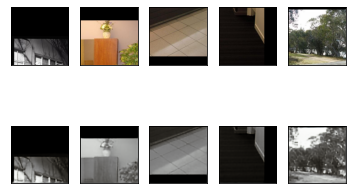

Epoch : [13/50] 

Train Loss: 5.909678	 val Loss: 5.794271	 lr : 0.001
PNSR :24.17 	 SSIM : 0.89
PNSR :18.32 	 SSIM : 0.81
PNSR :24.98 	 SSIM : 0.94
PNSR :25.80 	 SSIM : 0.94
PNSR :35.00 	 SSIM : 0.97
average_PNSR :25.66 	 average_SSIM : 0.91


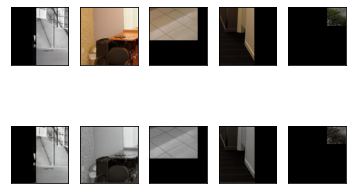

Epoch : [14/50] 

Train Loss: 5.830635	 val Loss: 5.932900	 lr : 0.001
PNSR :22.65 	 SSIM : 0.84
PNSR :20.40 	 SSIM : 0.89
PNSR :24.46 	 SSIM : 0.94
PNSR :24.42 	 SSIM : 0.95
PNSR :23.81 	 SSIM : 0.80
average_PNSR :23.15 	 average_SSIM : 0.88


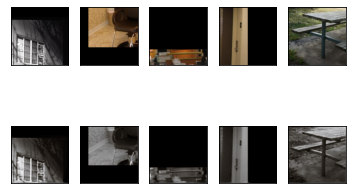

Epoch : [15/50] 

Train Loss: 5.818949	 val Loss: 5.832870	 lr : 0.001
PNSR :25.99 	 SSIM : 0.89
PNSR :55.13 	 SSIM : 1.00
PNSR :27.40 	 SSIM : 0.97
PNSR :27.22 	 SSIM : 0.97
PNSR :26.12 	 SSIM : 0.95
average_PNSR :32.37 	 average_SSIM : 0.95


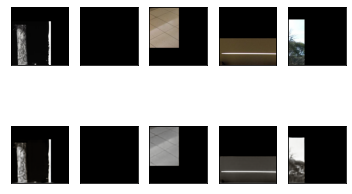

Epoch : [16/50] 

Train Loss: 5.689166	 val Loss: 6.107551	 lr : 0.001
PNSR :24.39 	 SSIM : 0.93
PNSR :18.86 	 SSIM : 0.89
PNSR :35.58 	 SSIM : 0.99
PNSR :25.00 	 SSIM : 0.93
PNSR :42.03 	 SSIM : 1.00
average_PNSR :29.17 	 average_SSIM : 0.95


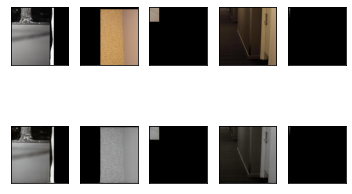

Epoch : [17/50] 

Train Loss: 5.801393	 val Loss: 5.601790	 lr : 0.001
PNSR :24.27 	 SSIM : 0.85
PNSR :18.28 	 SSIM : 0.87
PNSR :24.70 	 SSIM : 0.93
PNSR :36.62 	 SSIM : 1.00
PNSR :21.90 	 SSIM : 0.79
average_PNSR :25.15 	 average_SSIM : 0.89


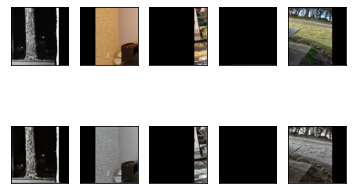

Epoch : [18/50] 

Train Loss: 5.634261	 val Loss: 5.643827	 lr : 0.001
PNSR :35.28 	 SSIM : 0.98
PNSR :18.06 	 SSIM : 0.82
PNSR :33.14 	 SSIM : 0.99
PNSR :24.71 	 SSIM : 0.96
PNSR :21.03 	 SSIM : 0.72
average_PNSR :26.44 	 average_SSIM : 0.90


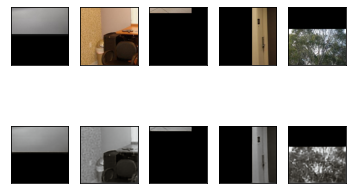

Epoch : [19/50] 

Train Loss: 5.809819	 val Loss: 5.764205	 lr : 0.001
PNSR :29.28 	 SSIM : 0.95
PNSR :22.13 	 SSIM : 0.92
PNSR :28.20 	 SSIM : 0.96
PNSR :34.82 	 SSIM : 0.98
PNSR :30.22 	 SSIM : 0.99
average_PNSR :28.93 	 average_SSIM : 0.96


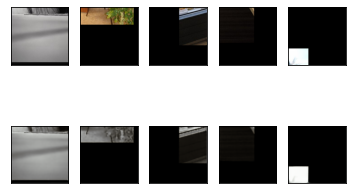

Epoch : [20/50] 

Train Loss: 5.643090	 val Loss: 5.815525	 lr : 0.001
PNSR :30.04 	 SSIM : 0.97
PNSR :20.24 	 SSIM : 0.94
PNSR :25.73 	 SSIM : 0.95
PNSR :25.07 	 SSIM : 0.90
PNSR :36.70 	 SSIM : 0.98
average_PNSR :27.56 	 average_SSIM : 0.95


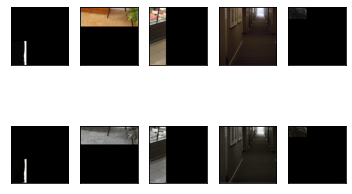

Epoch : [21/50] 

Train Loss: 5.633607	 val Loss: 5.646759	 lr : 0.001
PNSR :25.41 	 SSIM : 0.89
PNSR :18.49 	 SSIM : 0.76
PNSR :22.09 	 SSIM : 0.86
PNSR :24.72 	 SSIM : 0.94
PNSR :36.93 	 SSIM : 0.99
average_PNSR :25.53 	 average_SSIM : 0.89


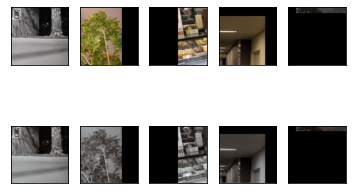

Epoch : [22/50] 

Train Loss: 5.518860	 val Loss: 5.531179	 lr : 0.001
PNSR :23.19 	 SSIM : 0.90
PNSR :26.20 	 SSIM : 0.98
PNSR :21.81 	 SSIM : 0.83
PNSR :29.35 	 SSIM : 0.99
PNSR :22.52 	 SSIM : 0.80
average_PNSR :24.61 	 average_SSIM : 0.90


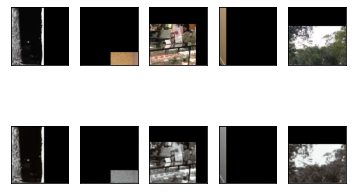

Epoch : [23/50] 

Train Loss: 5.532880	 val Loss: 5.636690	 lr : 0.001
PNSR :32.77 	 SSIM : 1.00
PNSR :19.75 	 SSIM : 0.91
PNSR :32.21 	 SSIM : 0.99
PNSR :22.27 	 SSIM : 0.89
PNSR :31.91 	 SSIM : 0.96
average_PNSR :27.78 	 average_SSIM : 0.95


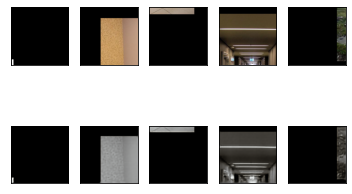

Epoch : [24/50] 

Train Loss: 5.506504	 val Loss: 5.540208	 lr : 0.001
PNSR :24.15 	 SSIM : 0.87
PNSR :24.02 	 SSIM : 0.96
PNSR :33.09 	 SSIM : 0.99
PNSR :27.48 	 SSIM : 0.94
PNSR :21.98 	 SSIM : 0.78
average_PNSR :26.14 	 average_SSIM : 0.91


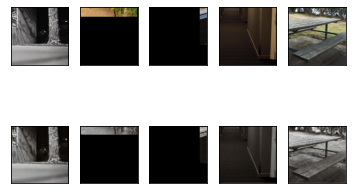

Epoch : [25/50] 

Train Loss: 5.476339	 val Loss: 5.650351	 lr : 0.001
PNSR :25.77 	 SSIM : 0.95
PNSR :16.43 	 SSIM : 0.86
PNSR :31.35 	 SSIM : 0.99
PNSR :20.89 	 SSIM : 0.82
PNSR :26.35 	 SSIM : 0.89
average_PNSR :24.16 	 average_SSIM : 0.90


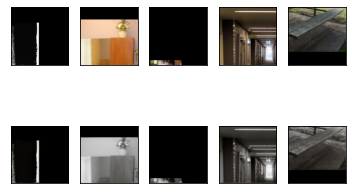

Epoch : [26/50] 

Train Loss: 5.461842	 val Loss: 5.661106	 lr : 0.001
PNSR :29.58 	 SSIM : 0.95
PNSR :14.60 	 SSIM : 0.63
PNSR :19.21 	 SSIM : 0.70
PNSR :36.80 	 SSIM : 0.98
PNSR :23.36 	 SSIM : 0.87
average_PNSR :24.71 	 average_SSIM : 0.83


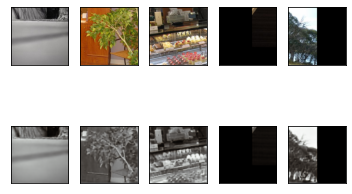

Epoch : [27/50] 

Train Loss: 5.447913	 val Loss: 5.587750	 lr : 0.001
PNSR :49.00 	 SSIM : 0.99
PNSR :34.34 	 SSIM : 1.00
PNSR :21.17 	 SSIM : 0.87
PNSR :23.24 	 SSIM : 0.92
PNSR :21.37 	 SSIM : 0.75
average_PNSR :29.82 	 average_SSIM : 0.91


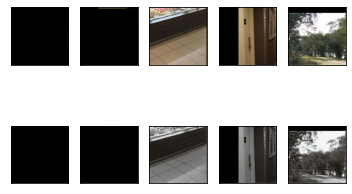

Epoch : [28/50] 

Train Loss: 5.392125	 val Loss: 5.640259	 lr : 0.001
PNSR :24.09 	 SSIM : 0.98
PNSR :14.33 	 SSIM : 0.64
PNSR :19.09 	 SSIM : 0.73
PNSR :26.88 	 SSIM : 0.94
PNSR :25.66 	 SSIM : 0.90
average_PNSR :22.01 	 average_SSIM : 0.84


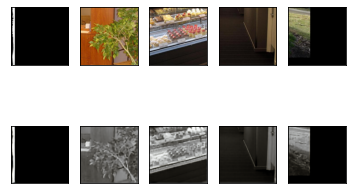

Epoch : [29/50] 

Train Loss: 5.435995	 val Loss: 5.338313	 lr : 0.0005
PNSR :30.89 	 SSIM : 0.95
PNSR :22.41 	 SSIM : 0.89
PNSR :21.12 	 SSIM : 0.81
PNSR :23.64 	 SSIM : 0.92
PNSR :21.31 	 SSIM : 0.72
average_PNSR :23.87 	 average_SSIM : 0.86


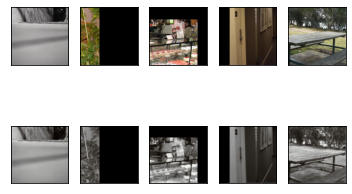

Epoch : [30/50] 

Train Loss: 5.272617	 val Loss: 5.275058	 lr : 0.0005
PNSR :25.33 	 SSIM : 0.81
PNSR :26.17 	 SSIM : 0.98
PNSR :22.35 	 SSIM : 0.87
PNSR :24.70 	 SSIM : 0.93
PNSR :25.38 	 SSIM : 0.92
average_PNSR :24.78 	 average_SSIM : 0.90


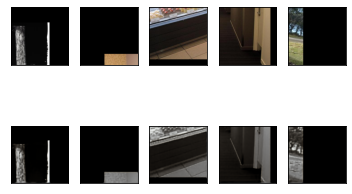

Epoch : [31/50] 

Train Loss: 5.283883	 val Loss: 5.373738	 lr : 0.0005
PNSR :22.53 	 SSIM : 0.80
PNSR :14.77 	 SSIM : 0.70
PNSR :37.02 	 SSIM : 1.00
PNSR :26.83 	 SSIM : 0.97
PNSR :28.54 	 SSIM : 0.91
average_PNSR :25.94 	 average_SSIM : 0.88


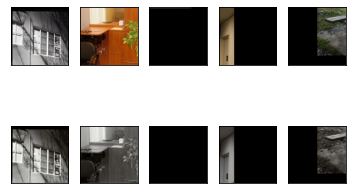

Epoch : [32/50] 

Train Loss: 5.273098	 val Loss: 5.231590	 lr : 0.0005
PNSR :30.16 	 SSIM : 0.97
PNSR :18.48 	 SSIM : 0.89
PNSR :19.73 	 SSIM : 0.74
PNSR :29.37 	 SSIM : 0.96
PNSR :20.27 	 SSIM : 0.66
average_PNSR :23.60 	 average_SSIM : 0.84


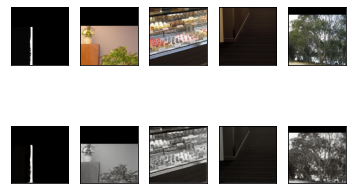

Epoch : [33/50] 

Train Loss: 5.331776	 val Loss: 5.318292	 lr : 0.0005
PNSR :29.26 	 SSIM : 0.96
PNSR :16.34 	 SSIM : 0.73
PNSR :27.25 	 SSIM : 0.97
PNSR :30.12 	 SSIM : 0.96
PNSR :21.37 	 SSIM : 0.81
average_PNSR :24.87 	 average_SSIM : 0.89


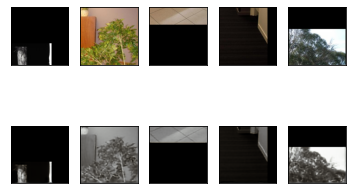

Epoch : [34/50] 

Train Loss: 5.296844	 val Loss: 5.340261	 lr : 0.0005
PNSR :25.67 	 SSIM : 0.89
PNSR :22.85 	 SSIM : 0.96
PNSR :29.39 	 SSIM : 0.98
PNSR :26.22 	 SSIM : 0.96
PNSR :36.46 	 SSIM : 0.98
average_PNSR :28.12 	 average_SSIM : 0.95


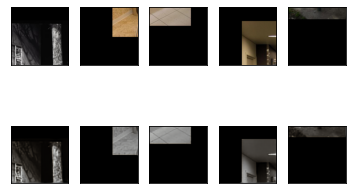

Epoch : [35/50] 

Train Loss: 5.297998	 val Loss: 5.433752	 lr : 0.0005
PNSR :28.61 	 SSIM : 0.95
PNSR :20.28 	 SSIM : 0.90
PNSR :20.70 	 SSIM : 0.82
PNSR :26.55 	 SSIM : 0.95
PNSR :20.91 	 SSIM : 0.72
average_PNSR :23.41 	 average_SSIM : 0.87


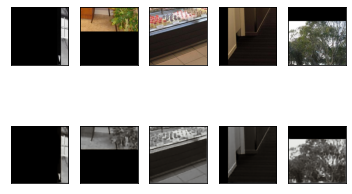

Epoch : [36/50] 

Train Loss: 5.271962	 val Loss: 5.371902	 lr : 0.0005
PNSR :24.17 	 SSIM : 0.89
PNSR :15.74 	 SSIM : 0.76
PNSR :28.45 	 SSIM : 0.97
PNSR :24.31 	 SSIM : 0.96
PNSR :33.80 	 SSIM : 0.97
average_PNSR :25.30 	 average_SSIM : 0.91


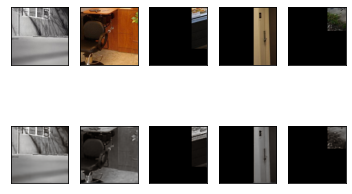

Epoch : [37/50] 

Train Loss: 5.235518	 val Loss: 5.367786	 lr : 0.0005
PNSR :32.24 	 SSIM : 0.99
PNSR :33.09 	 SSIM : 0.99
PNSR :22.04 	 SSIM : 0.84
PNSR :35.38 	 SSIM : 0.99
PNSR :19.83 	 SSIM : 0.79
average_PNSR :28.52 	 average_SSIM : 0.92


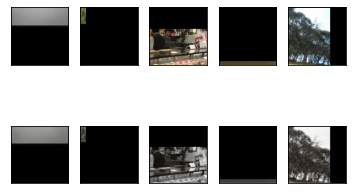

Epoch : [38/50] 

Train Loss: 5.244211	 val Loss: 5.297794	 lr : 0.0005
PNSR :26.32 	 SSIM : 0.88
PNSR :40.57 	 SSIM : 1.00
PNSR :30.40 	 SSIM : 0.99
PNSR :27.32 	 SSIM : 0.96
PNSR :39.04 	 SSIM : 0.99
average_PNSR :32.73 	 average_SSIM : 0.96


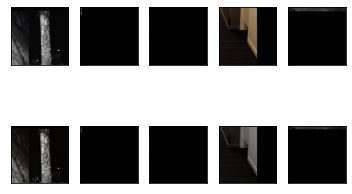

Epoch : [39/50] 

Train Loss: 5.166943	 val Loss: 5.222387	 lr : 0.00025
PNSR :38.06 	 SSIM : 0.99
PNSR :16.03 	 SSIM : 0.69
PNSR :28.59 	 SSIM : 0.97
PNSR :32.69 	 SSIM : 0.97
PNSR :25.67 	 SSIM : 0.93
average_PNSR :28.21 	 average_SSIM : 0.91


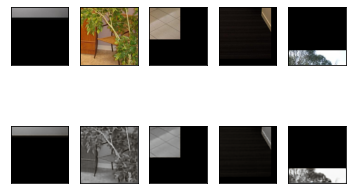

Epoch : [40/50] 

Train Loss: 5.151242	 val Loss: 5.172599	 lr : 0.00025
PNSR :50.10 	 SSIM : 1.00
PNSR :18.83 	 SSIM : 0.78
PNSR :20.64 	 SSIM : 0.76
PNSR :30.22 	 SSIM : 0.99
PNSR :31.48 	 SSIM : 0.97
average_PNSR :30.25 	 average_SSIM : 0.90


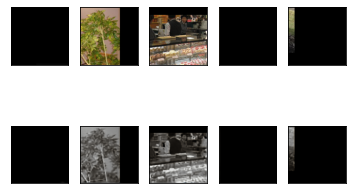

Epoch : [41/50] 

Train Loss: 5.206160	 val Loss: 5.278086	 lr : 0.00025
PNSR :25.15 	 SSIM : 0.89
PNSR :24.48 	 SSIM : 0.99
PNSR :23.65 	 SSIM : 0.87
PNSR :29.90 	 SSIM : 0.98
PNSR :24.25 	 SSIM : 0.88
average_PNSR :25.48 	 average_SSIM : 0.92


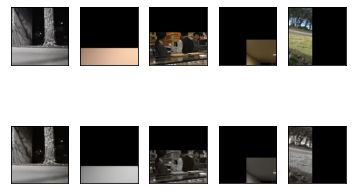

Epoch : [42/50] 

Train Loss: 5.102041	 val Loss: 5.156968	 lr : 0.00025
PNSR :24.65 	 SSIM : 0.88
PNSR :17.77 	 SSIM : 0.86
PNSR :19.87 	 SSIM : 0.72
PNSR :25.66 	 SSIM : 0.95
PNSR :21.58 	 SSIM : 0.71
average_PNSR :21.90 	 average_SSIM : 0.82


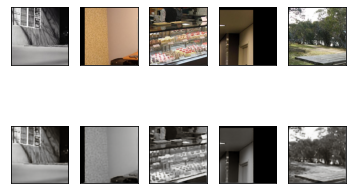

Epoch : [43/50] 

Train Loss: 5.174918	 val Loss: 5.253454	 lr : 0.00025
PNSR :34.80 	 SSIM : 0.98
PNSR :18.29 	 SSIM : 0.76
PNSR :19.44 	 SSIM : 0.74
PNSR :48.51 	 SSIM : 1.00
PNSR :33.98 	 SSIM : 0.99
average_PNSR :31.00 	 average_SSIM : 0.89


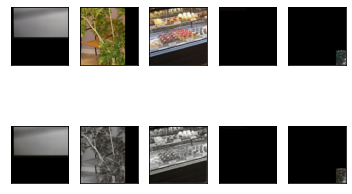

Epoch : [44/50] 

Train Loss: 5.186514	 val Loss: 4.911393	 lr : 0.00025
PNSR :41.16 	 SSIM : 0.99
PNSR :24.31 	 SSIM : 0.98
PNSR :24.51 	 SSIM : 0.91
PNSR :33.07 	 SSIM : 0.97
PNSR :22.40 	 SSIM : 0.79
average_PNSR :29.09 	 average_SSIM : 0.93


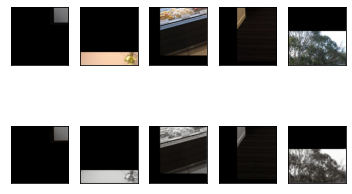

Epoch : [45/50] 

Train Loss: 5.278551	 val Loss: 5.164606	 lr : 0.00025
PNSR :27.19 	 SSIM : 0.93
PNSR :14.03 	 SSIM : 0.65
PNSR :21.46 	 SSIM : 0.84
PNSR :43.26 	 SSIM : 0.99
PNSR :21.64 	 SSIM : 0.75
average_PNSR :25.52 	 average_SSIM : 0.83


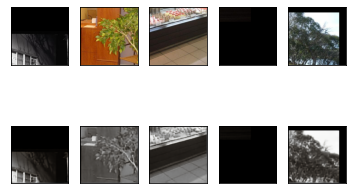

Epoch : [46/50] 

Train Loss: 5.141226	 val Loss: 5.256837	 lr : 0.00025
PNSR :38.50 	 SSIM : 0.99
PNSR :41.17 	 SSIM : 1.00
PNSR :25.19 	 SSIM : 0.94
PNSR :39.06 	 SSIM : 0.98
PNSR :22.28 	 SSIM : 0.77
average_PNSR :33.24 	 average_SSIM : 0.93


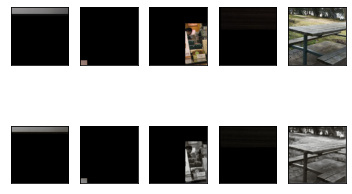

Epoch : [47/50] 

Train Loss: 5.110163	 val Loss: 5.216793	 lr : 0.00025
PNSR :33.55 	 SSIM : 0.98
PNSR :22.21 	 SSIM : 0.95
PNSR :24.21 	 SSIM : 0.91
PNSR :39.62 	 SSIM : 0.99
PNSR :22.11 	 SSIM : 0.81
average_PNSR :28.34 	 average_SSIM : 0.93


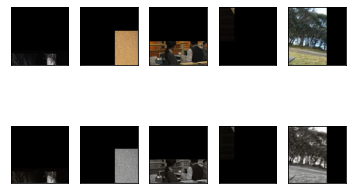

Epoch : [48/50] 

Train Loss: 5.165026	 val Loss: 5.068457	 lr : 0.00025
PNSR :41.61 	 SSIM : 0.99
PNSR :19.21 	 SSIM : 0.90
PNSR :26.59 	 SSIM : 0.96
PNSR :40.11 	 SSIM : 0.99
PNSR :33.27 	 SSIM : 0.97
average_PNSR :32.16 	 average_SSIM : 0.96


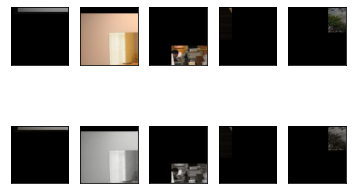

Epoch : [49/50] 

Train Loss: 5.123776	 val Loss: 5.168465	 lr : 0.00025
PNSR :29.84 	 SSIM : 0.99
PNSR :20.27 	 SSIM : 0.83
PNSR :20.94 	 SSIM : 0.81
PNSR :26.88 	 SSIM : 0.98
PNSR :33.03 	 SSIM : 1.00
average_PNSR :26.19 	 average_SSIM : 0.92


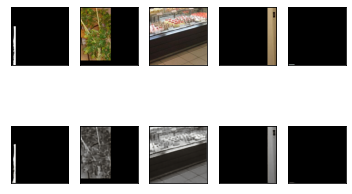

Epoch : [50/50] 

Train Loss: 5.085306	 val Loss: 5.068081	 lr : 0.00025
PNSR :23.64 	 SSIM : 0.85
PNSR :17.38 	 SSIM : 0.87
PNSR :22.65 	 SSIM : 0.85
PNSR :25.21 	 SSIM : 0.96
PNSR :29.20 	 SSIM : 0.98
average_PNSR :23.62 	 average_SSIM : 0.90


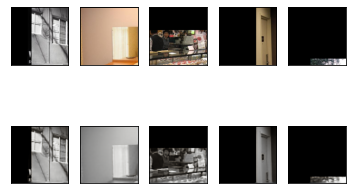

execution time : 506.4min


In [41]:
#배치 노말라이제이션을 적용한 경우!! 버젼관리 필요
n_epochs = 50

device = get_device()
print(device)
ms_ssim_loss_fn = MS_SSIM_Loss(data_range = 1.0, size_average = True, channel = 3).to(device)


model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-04)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience=5, mode='min')    
train_loss_graph = np.array([]) # 손실 그래프
val_loss_graph = np.array([])


start = time.time()




for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")

    model.train()
    train_loss = 0.0       #훈련 손실값
    total_train_loss = 0.0
    val_loss = 0.0         #검증 손실값
    total_val_loss = 0.0

    #훈련
    for i,(tr_img, _) in enumerate(tr_dataloader):

        tr_img = tr_img.to(device) #입력 이미지
        tr_outputs = model(tr_img) #복원 이미지
        optimizer.zero_grad()
        ms_ssim_loss = ms_ssim_loss_fn(tr_outputs, tr_img)
        ms_ssim_loss.backward()
        optimizer.step()

        train_loss = ms_ssim_loss.detach().cpu().item()
        total_train_loss += train_loss

    total_train_loss = total_train_loss/len(tr_dataloader) #평균 훈련 손실값
    train_loss_graph = np.append(train_loss_graph, total_train_loss)

    #검증
    model.eval()
    with torch.no_grad():
        optimizer.zero_grad()

        for i, (val_img,_) in enumerate(val_dataloader):
                val_img = val_img.to(device)
                val_outputs =model(val_img)
                val_ms_ssim_loss = ms_ssim_loss_fn(val_outputs,val_img)
                val_loss = val_ms_ssim_loss.cpu().item()
                total_val_loss += val_loss
        total_val_loss = total_val_loss/len(val_dataloader)
        val_loss_graph = np.append(val_loss_graph, total_val_loss)
        print('Train Loss: {:.6f}\t val Loss: {:.6f}\t lr : {}'.format(total_train_loss, total_val_loss, scheduler.optimizer.state_dict()['param_groups'][0]['lr']))


        if (epoch)%1 == 0:
            total_psnr = 0
            total_ssim = 0
            for j in range(5):
                val_ssim = skimage_ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True)
                val_psnr = peak_signal_noise_ratio(val_img[j].cpu().numpy().transpose(1,2,0), val_outputs[j].cpu().numpy().transpose(1,2,0))
                total_psnr += val_psnr
                total_ssim += val_ssim
                print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
                ax = plt.subplot(2,5,j+1)
                plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax = plt.subplot(2,5,j+5+1)
                plt.imshow(val_outputs[j].cpu().numpy().transpose(1, 2, 0))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            print('average_PNSR :{:.2f} \t average_SSIM : {:.2f}'.format(total_psnr/5,total_ssim/5))
            plt.show()
    scheduler.step(total_val_loss)      
    
end = time.time()

total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(train_loss_graph,'r-*')
plt.plot(val_loss_graph,'b-*')
plt.legend(['train_loss','val_loss'])
plt.title("Places365")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.tight_layout()
plt.show()

In [19]:
# ##여러개의 sequence로 구성했을 때의 학습 시간은 1epoch당 1분 20초 최대 SSIM은 0.63, 최소 로스
# class Autoencoder(nn.Module):
#    def __init__(self):
#        super(Autoencoder, self).__init__()
#        self.encoder1 = nn.Sequential(
#            # conv 1

#            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
#            nn.BatchNorm2d(32),
#            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2, stride=2),
#         )

#        self.encoder2 = nn.Sequential(
#            # conv 2
#            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=2),
#            nn.BatchNorm2d(16),
#            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2, stride=2),
#        )

#        self.encoder3 = nn.Sequential(
#            # conv 3
#            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2),
#            nn.BatchNorm2d(8),
#            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=2, stride=2),
#        )
#            # conv 4
#        self.encoder4 = nn.Sequential(
#            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=2),
#            nn.ReLU(),
#        )

       

#        self.decoder1 = nn.Sequential(
#            # conv 7
#            nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=2),
#            nn.BatchNorm2d(8),
#            nn.ReLU(),
#        )
#        self.decoder2 = nn.Sequential(
#            # conv 8
#            nn.UpsamplingBilinear2d(scale_factor = 2),
#            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=2),
#            nn.BatchNorm2d(16),
#            nn.ReLU(),
#        )
#        self.decoder3 = nn.Sequential(
      
#            # conv 9
#            nn.UpsamplingBilinear2d(scale_factor = 2),         
#            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
#            nn.BatchNorm2d(32),
#            nn.ReLU(),
#        )
#        self.decoder4 = nn.Sequential(

#            nn.UpsamplingBilinear2d(scale_factor = 2),
#            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=5, stride=1, padding=2),
#            nn.Sigmoid()  

#            # TODO softmax deprecated
#        )

#    def forward(self, x):
#        x = self.encoder1(x)
#        x = self.encoder2(x)
#        x = self.encoder3(x)
#        x = self.encoder4(x)       

#        x = self.decoder1(x)
#        x = self.decoder2(x)
#        x = self.decoder3(x)
#        x = self.decoder4(x) 
        
#        return x

In [ ]:
summary(model,(3,96,96))
#MS_ssim : https://github.com/VainF/pytorch-msssim
#MS_ssim 손실함수 : https://github.com/VainF/pytorch-msssim/blob/master/tests/ae_example/train.py